In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import re

# 1. EDA

* 1.1 check global info of dataset

In [2]:
os.listdir('drive/MyDrive/Colab Notebooks/Projet_Tweeter')

['Untitled0.ipynb',
 'test.csv',
 'train.csv',
 '.ipynb_checkpoints',
 'train_clean.csv']

In [3]:
# import train set file
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Projet_Tweeter/train.csv')
print(df.shape)
df.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# check missing values in the train set
df.isnull().sum()/len(df)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [5]:
# check basic info of values
df.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


* 1.2 Data visualization 

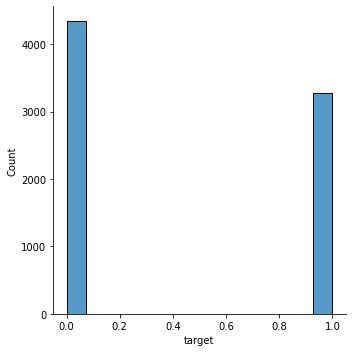

In [6]:
# distribution of 'target' values
sns.displot(df.target)

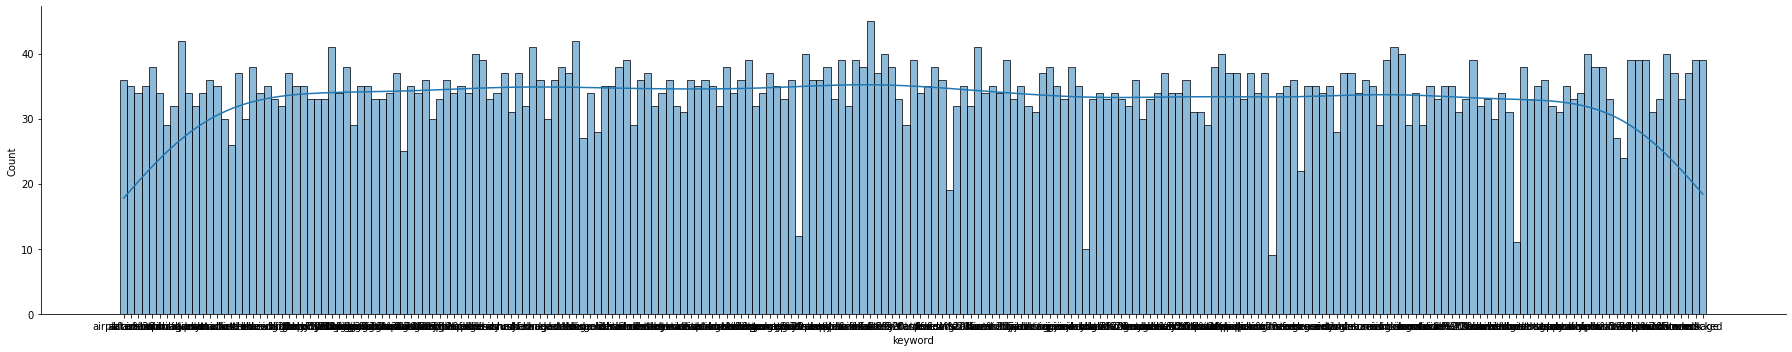

In [7]:
# distrubution of 'keyword' values
sns.displot(df.keyword,kde=True,aspect=5)

In [8]:
# clean data of location column, keep only letters
df.location.value_counts().index
df['location_clean'] = df['location'].dropna().apply(lambda x: ''.join(word for word in x if word.isalpha() or word ==' ' ))

In [9]:
df.loc[~df['location_clean'].isnull(),'location_clean'][0:100].values

array(['Birmingham', 'Est September   Bristol', 'AFRICA',
       'Philadelphia PA', 'London UK', 'Pretoria', 'World Wide',
       'Paranaque City', 'Live On Webcam', 'milky way',
       'GREENSBORONORTH CAROLINA', 'Live On Webcam', 'England',
       'Sheffield Township Ohio', 'India', 'Barbados', 'Anaheim', 'Abuja',
       'USA', 'South Africa', 'Sao Paulo Brazil', 'hollywoodland ',
       'Edmonton Alberta  Treaty ', 'Inang Pamantasan',
       'Twitter Lockout in progress', 'Concord CA', 'Calgary AB',
       'Birmingham', 'San Francisco', 'CLVLND', 'Nashville TN',
       'Santa Clara CA', 'UK', 'St Louis MO', 'Walker County Alabama',
       'Australia', 'North Carolina', 'Norf Carolina',
       'San Mateo County CA', 'North Carolina', 'Njoro Kenya',
       'Your Sisters Bedroom', 'Arlington TX', 'South Bloomfield OH',
       'New Hanover County NC', 'Maldives', 'Manchester NH',
       'Wilmington NC', 'New Hanover County NC', 'global',
       'Alberta  Sask  Montana', 'Charlotte', 'Ba

In [ ]:
# visualization of location data in maps

# get latitude and longitude of locations through API
import requests

lat=[]
lon=[]
top_100_locations = df.loc[~df['location_clean'].isnull(),'location_clean'][0:100].values
for i in top_100_locations:
  response = requests.get(f'https://nominatim.openstreetmap.org/?addressdetails=1&q={i}&format=json&limit=1')
  try:
    latitude = response.json()[0]['lat']
  except IndexError:
    pass
  try:
    longitude = response.json()[0]['lon']
  except IndexError:
    pass
 
  lat.append(latitude)
  lon.append(longitude)

# create a dateframe to save date of latitudes and longitudes
lat_lon = {'lat':lat,'lon':lon}
lat_lon = pd.DataFrame(lat_lon)
lat_lon['lat'] = lat_lon['lat'].apply(lambda x: float(x))
lat_lon['lon'] = lat_lon['lon'].apply(lambda x: float(x))


In [ ]:
# visualization of location through mapbox of plotly express
import plotly.express as px

px.scatter_mapbox(lat_lon,lat='lat', lon='lon',color=df.loc[~df['location_clean'].isnull(),'target'][0:100].values, mapbox_style ='carto-positron')

#2. Text proprecessing

* 2.1 Text understanding

In [10]:
# reading 50 texts to understand which processes should be done
for i in range(50):
  print(df.text[i])

# url should be removed
# special symbols should be removed 
# words after @ should be removed

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
I'm on top of the hill and I can see a fire in the woods...
There's an emergency evacuation happening now in the building across the street
I'm afraid that the tornado is coming to our area...
Three people died from the heat wave so far
Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
#raining #flooding #Florida 

* 2.1 Doing text cleaning by spacy 

In [12]:
# clean 'text' column by using spacy
!python -m spacy download en_core_web_sm -q

     |████████████████████████████████| 12.0 MB 5.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [13]:
from spacy.lang.en.stop_words import STOP_WORDS

import en_core_web_sm
nlp = en_core_web_sm.load()

In [14]:
# remove urls, words after @
df['text_clean'] = df['text'].apply(lambda x: re.sub(r"http\S+", "", x))
df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r"@\S+", "", x))

# remove all non alphanumeric characters except whitespaces
df['text_clean'] = df['text_clean'].apply(lambda x: ''.join(word for word in x if word.isalnum() or word ==' '))

# transfer double spces to one space, remove spaces at the begining and end of str
df['text_clean'] = df['text_clean'].apply(lambda x: x.replace(' +',' ').lower().strip())

# lemmatization of words and remove stop words
df['text_clean'] = df['text_clean'].apply(lambda x: ' '.join(token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)))

In [20]:
# check if there are missing values in text_clean column
df['text_clean'].isnull().sum()

0

In [40]:
train_clean = df.copy()
train_clean.head()

,id,keyword,location,text,target,location_clean,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN,deed reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NaN,send photo ruby alaska smoke wildfire pour school


* 1.3 Tokenizer words by tensorflow

In [41]:
# tokenizer clean text of dataset 
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_clean['text_clean'])

train_clean['text_clean_indexs'] = tokenizer.texts_to_sequences(train_clean['text_clean'])

In [42]:
train_clean.head()

,id,keyword,location,text,target,location_clean,text_clean,text_clean_indexs
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN,deed reason earthquake allah forgive,"[3591, 406, 163, 1362, 1929]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN,forest fire near la ronge sask canada,"[110, 2, 152, 501, 5340, 5341, 956]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN,resident ask shelter place notify officer evac...,"[1363, 440, 1685, 314, 5342, 285, 178, 1685, 3..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN,13000 people receive wildfire evacuation order...,"[2279, 6, 2280, 67, 178, 286, 34]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NaN,send photo ruby alaska smoke wildfire pour school,"[171, 115, 5343, 1930, 164, 67, 2281, 103]"


In [43]:
# check if there is empty list in text_clean_indexs, if yes, remove those lists

print(len(train_clean))

for x,i in zip(train_clean['text_clean_indexs'],train_clean['text_clean_indexs'].index):
  if len(x) == 0:
    train_clean.drop(i,inplace=True)
    train_clean.reset_index(drop=True,inplace=True)

print(len(train_clean))



7613
7607


In [44]:
train_clean.head()

,id,keyword,location,text,target,location_clean,text_clean,text_clean_indexs
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN,deed reason earthquake allah forgive,"[3591, 406, 163, 1362, 1929]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN,forest fire near la ronge sask canada,"[110, 2, 152, 501, 5340, 5341, 956]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN,resident ask shelter place notify officer evac...,"[1363, 440, 1685, 314, 5342, 285, 178, 1685, 3..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN,13000 people receive wildfire evacuation order...,"[2279, 6, 2280, 67, 178, 286, 34]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NaN,send photo ruby alaska smoke wildfire pour school,"[171, 115, 5343, 1930, 164, 67, 2281, 103]"


* 1.4 Using zero-padding to transfer all the sequences to the same length

In [45]:
indexs_pad = tf.keras.preprocessing.sequence.pad_sequences(train_clean['text_clean_indexs'], padding="post")

In [101]:
# save clean data as a csv file
train_clean.to_csv('drive/MyDrive/Colab Notebooks/Projet_Tweeter/clean_data.csv')

* 1.5 Organzing dataset per batch

In [46]:
# transfer pandas dataset to tensorflow dataset which contains only target column as text_clean_indexs column
x_train,x_val,y_train,y_val = train_test_split(indexs_pad,train_clean.target,test_size=0.2,random_state=0,stratify=train_clean.target)

train_batch = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(len(x_train)).batch(32)
val_batch = tf.data.Dataset.from_tensor_slices((x_val,y_val)).shuffle(len(x_val)).batch(32)

In [47]:
next(iter(train_batch))

(<tf.Tensor: shape=(32, 25), dtype=int32, numpy=
 array([[ 5052,  1836,   313,  1391,  4184,   539,    87,   661,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [ 5195,   164,   684,   483,   106,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  589,  9506,    20,   926,  3406,   125,  9507,  4750,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  921,     7,  4390,   118,  3264,   409,  4391,   843,   494,
           195,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  174,  2701,  9828,    23,  9829,  9830,  2157,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,   

# 2. Classification Modeling

In [82]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding,Dense, GRU, LSTM,SimpleRNN,GlobalAveragePooling1D
from tensorflow.keras.losses import BinaryCrossentropy  
from tensorflow.keras.metrics import Precision, Recall,BinaryAccuracy



In [49]:
# define parameters
vocab_size = len(tokenizer.word_index)
embedding_dim = 4

In [83]:
# simple Emnedding model
Emb_model = Sequential([
                    Embedding(vocab_size+1,embedding_dim),
                    GlobalAveragePooling1D(),
                    Dense(4,activation='relu'),
                    Dense(1,activation='sigmoid')
])


Emb_model.compile(optimizer='adam',
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy(),Precision(),Recall()])

Emb_history = Emb_model.fit(train_batch,validation_data=val_batch,epochs=20)

Epoch 1/20
191/191 [==============================] - 4s 10ms/step - loss: 0.6821 - binary_accuracy: 0.5704 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.6731 - val_binary_accuracy: 0.5703 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/20
191/191 [==============================] - 1s 5ms/step - loss: 0.6609 - binary_accuracy: 0.5804 - precision_1: 0.9841 - recall_1: 0.0237 - val_loss: 0.6449 - val_binary_accuracy: 0.6189 - val_precision_1: 0.9868 - val_recall_1: 0.1147
Epoch 3/20
191/191 [==============================] - 1s 3ms/step - loss: 0.6078 - binary_accuracy: 0.6996 - precision_1: 0.9712 - recall_1: 0.3099 - val_loss: 0.5883 - val_binary_accuracy: 0.7096 - val_precision_1: 0.9530 - val_recall_1: 0.3410
Epoch 4/20
191/191 [==============================] - 1s 3ms/step - loss: 0.5246 - binary_accuracy: 0.7936 - precision_1: 0.9398 - recall_1: 0.5551 - val_loss: 0.5182 - val_binary_accuracy: 0.7898 - val_precision_1: 0.9196 - val_recall_1: 0.5596

In [79]:
# define a function to calculate F1-score
def f1_score(precision,recall):
  F1_score=[]

  for a,b in zip(precision,recall):
    if a==0.0 or b==0.0:
      F1_score.append(0.0)
    else:
      re = 2*(a*b)/(a+b)
      F1_score.append(re)

  return F1_score

In [92]:
# visualization of loss evaluation and F1-score evaluation

fig = go.Figure()

fig.add_trace(go.Line(y=Emb_history.history['loss'],
                         name='train loss'))

fig.add_trace(go.Line(y=Emb_history.history['val_loss'],
                         name='val loss'))

fig.update_layout(title='Evaluation of loss',
                     xaxis_title='Epoch',
                     yaxis_title='Loss')

fig.show()

fig = go.Figure()

fig.add_trace(go.Line(y=f1_score(Emb_history.history['precision_1'],Emb_history.history['recall_1']),
                         name='train set F1-score'))

fig.add_trace(go.Line(y=f1_score(Emb_history.history['val_precision_1'],Emb_history.history['val_recall_1']),
                         name='val set F1-score'))

fig.update_layout(title='Evaluation of F1-score',
                     xaxis_title='Epoch',
                     yaxis_title='Accuracy')

fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [84]:
# RNN Model

model_rnn = Sequential([
                        Embedding(vocab_size+1,embedding_dim),
                        SimpleRNN(4),
                        Dense(4,activation='relu'),
                        Dense(1,activation='sigmoid')
])

model_rnn.compile(optimizer='adam',
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy(),Precision(),Recall()])

history_rnn = model_rnn.fit(train_batch,validation_data=val_batch,epochs=20)

Epoch 1/20
191/191 [==============================] - 4s 10ms/step - loss: 0.6899 - binary_accuracy: 0.5678 - precision_2: 0.4810 - recall_2: 0.0773 - val_loss: 0.6822 - val_binary_accuracy: 0.6143 - val_precision_2: 0.6618 - val_recall_2: 0.2095
Epoch 2/20
191/191 [==============================] - 2s 11ms/step - loss: 0.6540 - binary_accuracy: 0.7016 - precision_2: 0.7207 - recall_2: 0.4985 - val_loss: 0.6475 - val_binary_accuracy: 0.6721 - val_precision_2: 0.6386 - val_recall_2: 0.5459
Epoch 3/20
191/191 [==============================] - 3s 14ms/step - loss: 0.5508 - binary_accuracy: 0.8071 - precision_2: 0.8875 - recall_2: 0.6308 - val_loss: 0.6035 - val_binary_accuracy: 0.7083 - val_precision_2: 0.8144 - val_recall_2: 0.4159
Epoch 4/20
191/191 [==============================] - 3s 15ms/step - loss: 0.4894 - binary_accuracy: 0.8332 - precision_2: 0.9246 - recall_2: 0.6660 - val_loss: 0.6167 - val_binary_accuracy: 0.7083 - val_precision_2: 0.7313 - val_recall_2: 0.5076
Epoch 5/20
1

In [93]:
fig = go.Figure()

fig.add_trace(go.Line(y=history_rnn.history['loss'],
                         name='train loss'))

fig.add_trace(go.Line(y=history_rnn.history['val_loss'],
                         name='val loss'))

fig.update_layout(title='Evaluation of loss',
                     xaxis_title='Epoch',
                     yaxis_title='Loss')

fig.show()

fig = go.Figure()

fig.add_trace(go.Line(y=f1_score(history_rnn.history['precision_2'],history_rnn.history['recall_2']),
                         name='train set F1-score'))

fig.add_trace(go.Line(y=f1_score(history_rnn.history['val_precision_2'],history_rnn.history['val_recall_2']),
                         name='val set F1-score'))

fig.update_layout(title='Evaluation of F1-score',
                     xaxis_title='Epoch',
                     yaxis_title='Accuracy')

fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [94]:
# GRU model


model_gru = Sequential([
                  Embedding(vocab_size+1,embedding_dim),
                  GRU(4),
                  Dense(4,activation='relu'),
                  Dense(1,activation='sigmoid')

])

model_gru.compile(optimizer='adam',
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy(),Precision(),Recall()])

history_gru = model_gru.fit(train_batch,validation_data=val_batch,epochs=20)

Epoch 1/20
191/191 [==============================] - 6s 18ms/step - loss: 0.6842 - binary_accuracy: 0.5704 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.6828 - val_binary_accuracy: 0.5703 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/20
191/191 [==============================] - 3s 16ms/step - loss: 0.6801 - binary_accuracy: 0.5704 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.6726 - val_binary_accuracy: 0.5703 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/20
191/191 [==============================] - 3s 16ms/step - loss: 0.5333 - binary_accuracy: 0.7380 - precision_3: 0.8576 - recall_3: 0.4679 - val_loss: 0.4806 - val_binary_accuracy: 0.7943 - val_precision_3: 0.7412 - val_recall_3: 0.8012
Epoch 4/20
191/191 [==============================] - 3s 15ms/step - loss: 0.3377 - binary_accuracy: 0.8771 - precision_3: 0.8843 - recall_3: 0.8213 - val_loss: 0.4542 - val_binary_accuracy: 0.8055 - val_precision_3: 0.7841 - v

In [95]:
# visualization of loss and accuracy 
fig = go.Figure()

fig.add_trace(go.Line(y=history_gru.history['loss'],
                         name='train loss'))

fig.add_trace(go.Line(y=history_gru.history['val_loss'],
                         name='val loss'))

fig.update_layout(title='Evaluation of loss',
                     xaxis_title='Epoch',
                     yaxis_title='Loss')
fig.show()

fig = go.Figure()

fig.add_trace(go.Line(y=f1_score(history_gru.history['precision_3'],history_gru.history['recall_3']),
                         name='train set F1-score'))

fig.add_trace(go.Line(y=f1_score(history_gru.history['val_precision_3'],history_gru.history['val_recall_3']),
                         name='val set F1-score'))

fig.update_layout(title='Evaluation of F1-score',
                     xaxis_title='Epoch',
                     yaxis_title='Accuracy')
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [98]:
# LSTM model

model_lstm = Sequential([
                  Embedding(vocab_size+1,embedding_dim),
                  LSTM(4),
                  Dense(4,activation='relu'),
                  Dense(1,activation='sigmoid')

])

model_lstm.compile(optimizer='adam',
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy(),Precision(),Recall()])

history_lstm = model_lstm.fit(train_batch,validation_data=val_batch,epochs=20)

Epoch 1/20
191/191 [==============================] - 6s 17ms/step - loss: 0.6866 - binary_accuracy: 0.5627 - precision_4: 0.3956 - recall_4: 0.0340 - val_loss: 0.6821 - val_binary_accuracy: 0.5703 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/20
191/191 [==============================] - 3s 13ms/step - loss: 0.6416 - binary_accuracy: 0.5704 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 0.5580 - val_binary_accuracy: 0.5703 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 3/20
191/191 [==============================] - 3s 13ms/step - loss: 0.4859 - binary_accuracy: 0.8551 - precision_4: 0.8503 - recall_4: 0.8041 - val_loss: 0.5350 - val_binary_accuracy: 0.8081 - val_precision_4: 0.7802 - val_recall_4: 0.7706
Epoch 4/20
191/191 [==============================] - 3s 14ms/step - loss: 0.4018 - binary_accuracy: 0.8955 - precision_4: 0.8633 - recall_4: 0.8990 - val_loss: 0.5500 - val_binary_accuracy: 0.7917 - val_precision_4: 0.7580 - val_recal

In [99]:
# visualization of loss and accuracy
fig = go.Figure()

fig.add_trace(go.Line(y=history_lstm.history['loss'],
                         name='train loss'))

fig.add_trace(go.Line(y=history_lstm.history['val_loss'],
                         name='val loss'))

fig.update_layout(title='Evaluation of loss',
                     xaxis_title='Epoch',
                     yaxis_title='Loss')

fig.show()

fig = go.Figure()

fig.add_trace(go.Line(y=f1_score(history_lstm.history['precision_4'],history_lstm.history['recall_4']),
                         name='train set F1-score'))

fig.add_trace(go.Line(y=f1_score(history_lstm.history['val_precision_4'],history_lstm.history['val_recall_4']),
                         name='val set F1-score'))

fig.update_layout(title='Evaluation of F1-score',
                     xaxis_title='Epoch',
                     yaxis_title='Accuracy')
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [ ]:
# change hyper parameters to reduce overfitting

